В данном ноутбуке представлены эксперименты с моделями для решения задачи классификации отзывов к фильмам. Требуется классифицировать оценку пользователя к фильму и эмоциональную оценку отзыва (хоршиее впечатление от фильма или плохое). В качестве набора данных использовался Large Movie Review Dataset. В набре данных присутствуют оценки от 1 до 4 (плохое впечатление) и от 6 до 10 (хорошее).

In [3]:
import os
import pandas as pd
import numpy as np
import random as rnd
import re
import string
from nltk.tokenize import WordPunctTokenizer
from pymystem3 import Mystem
import nltk
from math import sqrt

from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
tokenizer = WordPunctTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words("english")

In [5]:
SEED = 42
np.random.seed(SEED)
rnd.seed(SEED)

Загрузка данных

In [6]:
train_dir = "aclImdb/train"
test_dir = "aclImdb/test"

In [7]:
def load_data(path):
    data_dict = {
        "text":[],
        "score":[],
        "sentiment":[]
    }

    for file in os.listdir(f"{path}/pos"):
        with open(f"{path}/pos/{file}", "r") as f:
            data_dict["text"].append("".join(f.readlines()))
        filename = file.split(".")[0]
        score = int(filename.split("_")[1])
        data_dict["score"].append(score)
        data_dict["sentiment"].append(1)

    for file in os.listdir(f"{path}/neg"):
        with open(f"{path}/neg/{file}", "r") as f:
            data_dict["text"].append("".join(f.readlines()))
        filename = file.split(".")[0]
        score = int(filename.split("_")[1])
        data_dict["score"].append(score)
        data_dict["sentiment"].append(0)
    return pd.DataFrame(data_dict)

In [8]:
df_train = load_data(train_dir)
df_test = load_data(test_dir)

Предобработка данных. Из предложений ислючаются знаки пунктуации, цифры и стоп слова. Далее каждое слово приводится к его начальной форме с помощью WordNetLemmatizer из библиотеки nltk. 

Также корректируются оценки:

от 0 до 3 - плохое впечатление

от 4 до 7 - хорошее впечатление



In [9]:
def preprocess_text(text, tokenizer=tokenizer):
    text = re.sub("<br />", "", text)

    sents = []
    for sent in text.lower().split("."):
        preprocessed_sent = []
        for word in tokenizer.tokenize(sent):
            if (word not in stopwords) and (word not in string.punctuation) \
                    and (not word.isdigit()):
                lemmatize_word = lemmatizer.lemmatize(word)
                preprocessed_sent.append(lemmatize_word)
        sents.append(" ".join(preprocessed_sent))
    return " ".join(sents)

def score_corrector(label):
    if label > 6:
        return label - 3
    return label - 1

In [10]:
df_train["lemmatize_text"] = df_train["text"].apply(preprocess_text)
df_test["lemmatize_text"] = df_test["text"].apply(preprocess_text)

df_train["score"] = df_train["score"].apply(score_corrector)
df_test["score"] = df_test["score"].apply(score_corrector)

Разделение выборки на train и val.

In [11]:
lemmatize_text = df_train["lemmatize_text"].to_numpy()
score = df_train["score"].to_numpy()

In [12]:
train_text, val_text, train_labels, val_labels = train_test_split(lemmatize_text, 
                                                                  score, 
                                                                  test_size=0.3, 
                                                                  random_state=SEED)

In [19]:
def print_metrics(y_test, y_pred):
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Macro precision: ", precision_score(y_test, y_pred, average="macro"))
    print("Micro precision: ", precision_score(y_test, y_pred, average="micro"))
    print("Macro recall: ", recall_score(y_test, y_pred, average="macro"))
    print("Micro recall: ", recall_score(y_test, y_pred, average="micro"))
    print("Macro f1-score: ", f1_score(y_test, y_pred, average="macro"))
    print("Micro f1-score: ", f1_score(y_test, y_pred, average="micro"))

In [20]:
def print_sentiment_metrics(y_test, y_pred):
    y_test = y_test > 4
    y_pred = y_pred > 4
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Precision: ", precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("F1-score: ", f1_score(y_test, y_pred))

### TF-IDF

В первую очередь проведем эксперименты с tf-idf на классических моделях, а именно на случайном лесе, логистической регрессии и SVM.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=5)
train_vectorize = tfidf_vectorizer.fit_transform(train_text)
val_vectorize = tfidf_vectorizer.transform(val_text)
print(train_vectorize.shape)

(17500, 20225)


Случайный лес

In [ ]:
rf = RandomForestClassifier(
    class_weight="balanced", 
    random_state=SEED
)
rf.fit(train_vectorize, train_labels)

pred_rf_tfidf = rf.predict(val_vectorize)
print_metrics(val_labels, pred_rf_tfidf)

Accuracy:  0.3704
Macro precision:  0.35025195831120176
Micro precision:  0.3704
Macro recall:  0.25242613694067983
Micro recall:  0.3704
Macro f1-score:  0.18545276539490183
Micro f1-score:  0.3704


In [ ]:
print_sentiment_metrics(val_labels, pred_rf_tfidf)

Accuracy:  0.7810666666666667
Precision:  0.6883821932681867
Recall:  0.836963696369637
F1-score:  0.7554364015490022


Логистическая регрессия

In [ ]:
logreg = LogisticRegressionCV(
    multi_class="multinomial", 
    solver="newton-cg", 
    class_weight="balanced", 
    random_state=SEED
)
logreg.fit(train_vectorize, train_labels)

pred_logreg_tfidf = logreg.predict(val_vectorize)
print_metrics(val_labels, pred_logreg_tfidf)

Accuracy:  0.39453333333333335
Macro precision:  0.34930223792348364
Micro precision:  0.39453333333333335
Macro recall:  0.3500884391654889
Micro recall:  0.39453333333333335
Macro f1-score:  0.348773858464878
Micro f1-score:  0.39453333333333335


In [ ]:
print_sentiment_metrics(val_labels, pred_logreg_tfidf)

Accuracy:  0.8206666666666667
Precision:  0.7805527805527805
Recall:  0.7735973597359735
F1-score:  0.777059506050058


SVM

In [ ]:
linear_svc = LinearSVC(
    multi_class="crammer_singer", 
    class_weight="balanced", 
    random_state=SEED
)
linear_svc.fit(train_vectorize, train_labels)

pred_svc_tfidf = linear_svc.predict(val_vectorize)
print_metrics(val_labels, pred_svc_tfidf)

Accuracy:  0.358
Macro precision:  0.3200443551704755
Micro precision:  0.358
Macro recall:  0.31762523929464104
Micro recall:  0.358
Macro f1-score:  0.317878698059188
Micro f1-score:  0.35800000000000004


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
print_sentiment_metrics(val_labels, pred_svc_tfidf)

Accuracy:  0.8002666666666667
Precision:  0.7617908407382091
Recall:  0.7356435643564356
F1-score:  0.7484889187374077


Среди классических методов наилучшее качество дала логистическая регрессия.

### Нейросети

In [21]:
from tqdm.notebook import tqdm
from torchdata.datapipes.iter import IterableWrapper
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt 
import torch.nn as nn
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Создание словаря

In [23]:
def text_iterator(text):
    for row in text:
        yield tokenizer.tokenize(row)

In [24]:
text_vocab = build_vocab_from_iterator(text_iterator(train_text), 
                                       specials=["<unk>", "<pad>"], 
                                       min_freq=5)
text_vocab.set_default_index(text_vocab["<unk>"])
print(len(text_vocab))

21963


Предобработка данных перед подачей в нейросеть, а именно:
1. Токенизация предложений и замена слов на их индекс из словаря
2. Разделение данных на батчи, предварительно отсортиовав предложения по длине
3. Создание даталоадеров, в которых батчи преобразуются в torch.tensor

Перед преобразованием батчей в torch.tensor предложения приводятся к одной длине с помощью паддинга. Чем меньше предложения отличаются по длине друг от друга, тем меньше памяти будет тратится на паддинг. 

Построим box-plot для распределения количества слов в предложениях

<Axes: >

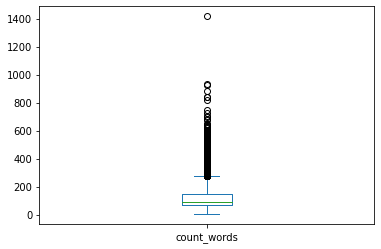

In [13]:
df_train["count_words"] = df_train["lemmatize_text"].apply(lambda x: len(x.split(" ")))
df_train["count_words"].plot(kind="box")

Посмотрим, у скольких предложений количество слов больше 300

In [14]:
len(df_train.query("count_words > 300"))

1442

In [15]:
1442 / 25000

0.05768

Только 5% предложений имеют количество слов, большее чем 300. Для уменьшения потребления памяти, ограничим количество слов в предложениях до 300.

In [25]:
def preprocess_pipe(row, tokenizer=tokenizer, vocab=text_vocab):
    tokens = vocab(tokenizer.tokenize(row[0])[:300])
    return (tokens, row[1])

def sort_keys(data):
    return sorted(data, key=lambda x: len(x[0]))

In [26]:
train_dp = IterableWrapper(zip(train_text, train_labels))
val_dp = IterableWrapper(zip(val_text, val_labels))

train_dp_prep = train_dp.map(preprocess_pipe)
val_dp_prep = val_dp.map(preprocess_pipe)

train_dp_bucket = train_dp_prep.bucketbatch(128, sort_key=sort_keys)
val_dp_bucket = val_dp_prep.bucketbatch(128, sort_key=sort_keys)

train_dataset = to_map_style_dataset(train_dp_bucket)
val_dataset = to_map_style_dataset(val_dp_bucket)

In [27]:
def batch_preprocess(batch):
    sent_list = []
    label_list = []
    for sent, label in batch:
        pad_sent = sent + [0]*(300 - len(sent))
        sent_list.append(pad_sent)
        label_list.append(label)
    sents_tensor = torch.tensor(sent_list, dtype=torch.int64).permute((1,0)).contiguous()
    labels_tensor = torch.tensor(label_list, dtype=torch.int64)

    return (sents_tensor, labels_tensor)

In [28]:
train_dataloader = DataLoader(train_dataset, batch_size=None, collate_fn=batch_preprocess, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=None, collate_fn=batch_preprocess)

Функции для обучения и оценки моделей

In [30]:
def train_step(model,
               dataloader,
               criterion,
               optimizer):
    mean_accuracy = 0.0
    mean_loss = 0.0
    count_sents = 0

    model.train()
    for batch in tqdm(dataloader):
        sents, labels = batch
        sents = sents.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = model(sents)

        pred_labels = pred.argmax(axis=1)
        mean_accuracy += (pred_labels == labels).sum().item()

        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        mean_loss += loss.detach()

        count_sents += sents.shape[1]
    
    mean_accuracy /= count_sents
    mean_loss /= count_sents

    return mean_accuracy, mean_loss

def val_step(model,
             dataloader,
             criterion):
    mean_accuracy = 0.0
    mean_loss = 0.0
    count_sents = 0

    model.eval()
    for batch in tqdm(dataloader):
        sents, labels = batch
        sents = sents.to(device)
        labels = labels.to(device)

        pred = model(sents)

        pred_labels = pred.argmax(axis=1)
        mean_accuracy += (pred_labels == labels).sum().item()

        loss = criterion(pred, labels)
        mean_loss += loss.detach()

        count_sents += sents.shape[1]
    
    mean_accuracy /= count_sents
    mean_loss /= count_sents
    
    return mean_accuracy, mean_loss

def train(model,
          train_dataloader,
          val_dataloader,
          criterion,
          optimizer,
          save_dir=None,
          scheduler=None,
          epochs=10):
    
    history = {
        "train_loss":[],
        "train_acc":[],
        "val_loss":[],
        "val_acc":[]
    }
    min_loss = 999999

    for epoch in tqdm(range(epochs)):
        train_acc, train_loss = train_step(model, 
                                        train_dataloader, 
                                        criterion, 
                                        optimizer)
        
        history["train_loss"].append(train_loss.item())
        history["train_acc"].append(train_acc)
        print(f"Epoch: {epoch}, Train_loss: {train_loss}, Train_acc: {train_acc}")

        val_acc, val_loss = val_step(model,
                                     val_dataloader,
                                     criterion)
        history["val_loss"].append(val_loss.item())
        history["val_acc"].append(val_acc)
        print(f"Epoch: {epoch}, Val_loss: {val_loss}, Val_acc: {val_acc}")
        if not save_dir is None and min_loss > val_loss:
            print("New best result!")
            best_loss = val_loss
            torch.save(model.state_dict(), save_dir)
    return history

def eval_model(model, dataloader):
    pred_labels = []
    true_labels = []
    
    model.eval()
    for batch in dataloader:
        sents, labels = batch
        sents = sents.to(device)

        pred = model(sents)

        pred_labels.extend(pred.argmax(axis=1).tolist())
        true_labels.extend(labels.tolist())
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    print_metrics(true_labels, pred_labels)
    print()
    print_sentiment_metrics(true_labels, pred_labels)
    return pred_labels

def draw_history(history):
    figure = plt.figure(figsize=(10, 10))
    gs = figure.add_gridspec(2, 1)

    figure.add_subplot(gs[0, 0])
    plt.plot(list(range(len(history["train_acc"]))), 
             history["train_acc"], 
             label="train_acc")
    plt.plot(list(range(len(history["val_acc"]))), 
             history["val_acc"], 
             label="val_acc")
    plt.legend()

    figure.add_subplot(gs[1, 0])
    plt.plot(list(range(len(history["train_loss"]))), 
             history["train_loss"], 
             label="train_loss")
    plt.plot(list(range(len(history["val_loss"]))), 
             history["val_loss"], 
             label="val_loss")
    plt.legend()

### EmbBag

Первая модель производит классификацию по усредненным эмбеддингам слов.

In [59]:
class EmbeddingBagModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.emb_bag = nn.EmbeddingBag(input_dim, 128)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(128, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, output_dim)
    
    def forward(self, x_input):
        x = x_input.permute((1, 0))
        x = self.dropout(self.emb_bag(x))
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)

        return x

In [31]:
class_weights = torch.tensor(
    compute_class_weight(
        'balanced',
        classes=df_train["score"].unique(),
        y=df_train["score"]
    ), 
    dtype=torch.float32
).to(device)

In [65]:
INPUT_DIM = len(text_vocab)
OUTPUT_DIM = 8
emb_bag_model = EmbeddingBagModel(INPUT_DIM, OUTPUT_DIM)
emb_bag_model.to(device)

lr = 0.001
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(emb_bag_model.parameters(), lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)
print("Params: ", sum([param.numel() for param in emb_bag_model.parameters()]))

Params:  2872072


In [ ]:
history = train(emb_bag_model, 
                train_dataloader,
                val_dataloader,
                criterion,
                optimizer,
                scheduler=scheduler,
                epochs=25)

In [67]:
labels = eval_model(emb_bag_model, val_dataloader)

Accuracy:  0.3778666666666667
Macro precision:  0.3797009341610834
Micro precision:  0.3778666666666667
Macro recall:  0.3125589254008257
Micro recall:  0.3778666666666667
Macro f1-score:  0.244902940299268
Micro f1-score:  0.37786666666666674

Accuracy:  0.766
Precision:  0.8524046434494196
Recall:  0.5089108910891089
F1-score:  0.6373217606943584


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


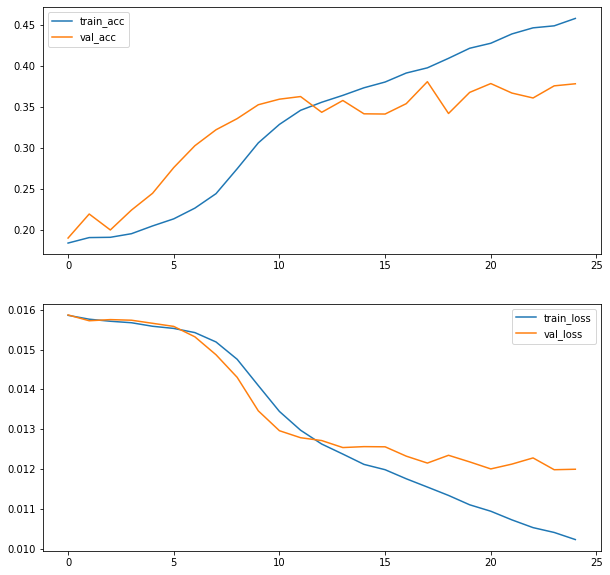

In [68]:
draw_history(history)

### RNN_Model

Вторая модель основана на рекуррентной сети BiLSTM с использованием ConcatAttention.

In [32]:
class ConcatAttention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.attn = nn.Linear(hid_dim*2, hid_dim)
        self.v = nn.Linear(hid_dim, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, hidden, outputs):
        hidden = hidden.unsqueeze(0)
        repeat_hidden = hidden.repeat((len(outputs), 1, 1)) 

        concat_hidden = torch.concat((repeat_hidden, outputs), axis=2)

        energy = torch.tanh(self.attn(concat_hidden))

        attention = self.softmax(self.v(energy))

        return attention

class RNNModel(nn.Module):
    def __init__(self, input_dim, output_dim, bidirectional=True):
        super().__init__()
        self.emb = nn.Embedding(input_dim, 64)

        self.rnn = nn.LSTM(64, 
                           128, 
                           bidirectional=True, 
                           num_layers=1) 
        self.attention = ConcatAttention(256)
        self.fc = nn.Linear(256, output_dim)
    
    def forward(self, x_input):
        x = self.emb(x_input)
        output, (h, c) = self.rnn(x)
        h = h.permute((1, 0 ,2)).reshape((x_input.shape[1], -1))
        attn = self.attention(h, output)
        x_attn = (attn * output).sum(axis=0)
        x = self.fc(x_attn)
        
        return x

In [36]:
INPUT_DIM = len(text_vocab)
OUTPUT_DIM = 8

rnn_model = RNNModel(INPUT_DIM, OUTPUT_DIM)
rnn_model.to(device)

lr = 0.0001
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr)
print("Params: ", sum([param.numel() for param in rnn_model.parameters()]))

Params:  1737929


In [ ]:
history = train(rnn_model,
                train_dataloader, 
                val_dataloader,
                criterion,
                optimizer,
                epochs=15)

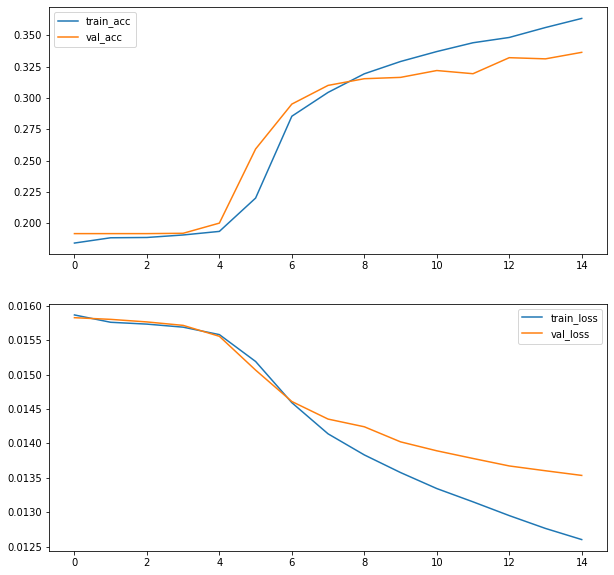

In [38]:
draw_history(history)

In [40]:
labels = eval_model(rnn_model, val_dataloader)

Accuracy:  0.3364
Macro precision:  0.1821153934157015
Micro precision:  0.3364
Macro recall:  0.25207281924151903
Micro recall:  0.3364
Macro f1-score:  0.20602350967838434
Micro f1-score:  0.3364

Accuracy:  0.7589333333333333
Precision:  0.6578194119177726
Recall:  0.8368090036411784
F1-score:  0.7365967365967367


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Среди двух рассмотреных нейросетевых моделей наилучшее качество имеет EmbeddingBagModel. 

Наилучшее качество серди всех рассмотренных моделей дала логистическая регрессия, которая и будет использоваться для классификации отзыва в веб-приложении.

Сохраним модель логистической регресии и tfidf_vectorizer, а также посчитаем значения метрик на тестовом наборе.

In [ ]:
import pickle

with open("tfidf_vectorizer.pickle", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("logreg.pickle", "wb") as f:
    pickle.dump(logreg, f)

In [22]:
test_text = df_test["lemmatize_text"].to_numpy()
test_labels = df_test["score"].to_numpy()
test_vectorize = tfidf_vectorizer.transform(test_text)

In [23]:
pred_logreg_test = logreg.predict(test_vectorize)
print_metrics(test_labels, pred_logreg_test)
print_sentiment_metrics(test_labels, pred_logreg_test)

Accuracy:  0.38292
Macro precision:  0.32789692383659697
Micro precision:  0.38292
Macro recall:  0.33034268520036536
Micro recall:  0.38292
Macro f1-score:  0.3284319406976689
Micro f1-score:  0.38292
Accuracy:  0.81452
Precision:  0.78077622801698
Recall:  0.7578730501324439
F1-score:  0.7691541793199582
